# Determination of a prospective tariff for a telecom company

Megaline is a federal mobile operator. Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.

It is necessary to make a preliminary analysis of tariffs on a small sample of customers. The data of 500 Megaline users is available: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.

## Data exploration

In [1]:
# Import libraries
import pandas as pd
import datetime as dt
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
# Get dataframes from files
data_calls = pd.read_csv('calls.csv')
data_internet = pd.read_csv('internet.csv')
data_messages = pd.read_csv('messages.csv')
data_tariffs = pd.read_csv('tariffs.csv')
data_users = pd.read_csv('users.csv')

In [3]:
# Get information about the data
data_calls.info()
data_internet.info()
data_messages.info()
data_tariffs.info()
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

In [4]:
# Print the first rows for all dataframes
display(data_calls.head())
display(data_internet.head())
display(data_messages.head())
display(data_tariffs.head())
display(data_users.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


## Data processing

There are gaps only in the dataframe of the sample, and they are logical (the expiration date of the tariff). We leave the gaps as they are.

In [5]:
data_internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [6]:
del data_internet['Unnamed: 0']

In [7]:
# Check data for duplicates
data_calls.duplicated().sum()

0

In [8]:
data_internet.duplicated().sum()

0

In [9]:
data_messages.duplicated().sum()

0

In [10]:
data_tariffs.duplicated().sum()

0

In [11]:
data_users.duplicated().sum()

0

## Data preparation

In [12]:
# Get month values for calculations
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
data_calls['month'] = data_calls['call_date'].dt.month

data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
data_internet['month'] = data_internet['session_date'].dt.month

data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
data_messages['month'] = data_messages['message_date'].dt.month

# Remove columns with the old date format as unnecessary
del data_calls['call_date']
del data_internet['session_date']
del data_messages['message_date']

## Preliminary calculations

In [13]:
# Consider rounding up
# For non-zero calls, drop the fractional part and add one, leave zero calls unchanged
data_calls['duration'] = data_calls[data_calls['duration'] != 0]['duration'].astype(int) + 1
data_calls['duration'] = data_calls['duration'].fillna(0)
data_calls['duration'] = data_calls['duration'].astype(int)

In [14]:
# number of calls made and spent minutes of conversation by month
calls = data_calls.pivot_table(aggfunc={'duration' : np.sum,'id' : len}, 
                       index=['user_id', 'month'], 
                       values=['id', 'duration']).rename(columns={'id' : 'calls_sum'})
# number of sent messages by month
messages = data_messages.pivot_table(aggfunc={'id' : len}, 
                          index=['user_id', 'month'], 
                          values=['id']).rename(columns={'id' : 'messages_sum'}).rename(columns={'month_messages' : 'month'})
# the amount of Internet traffic used by months
internet = data_internet.pivot_table(aggfunc={'mb_used' : np.sum}, 
                          index=['user_id', 'month'], 
                          values=['mb_used'])

In [15]:
# Get prepared table
data_full = pd.merge(internet, calls, on=['user_id', 'month'], how='outer').merge(messages, on=['user_id', 'month'], how='left')

# Fill in the gaps with 0, because pass means not using the service
data_full = data_full.fillna(0)
data_full

mb_used  duration  calls_sum  messages_sum
user_id month                                             
1000    5       2253.49     159.0       22.0          22.0
        6      23233.77     172.0       43.0          60.0
        7      14003.64     340.0       47.0          75.0
        8      14055.93     409.0       52.0          81.0
        9      14568.91     467.0       58.0          57.0
...                 ...       ...        ...           ...
1273    11         0.00     273.0       45.0          29.0
        12         0.00     261.0       41.0          39.0
1377    2          0.00     179.0       23.0           2.0
1392    2          0.00      13.0        2.0           3.0
1446    8          0.00      50.0        4.0           1.0

[3214 rows x 4 columns]

In [16]:
### monthly revenue per user
     # split the original dataframe into two - (by user category)
smart = data_users[data_users['tariff'] == 'smart']['user_id']
ultra = data_users[data_users['tariff'] == 'ultra']['user_id']
    # dataframes by tariffs
smart_users = data_full.query('user_id in @smart')
ultra_users = data_full.query('user_id in @ultra')

In [17]:
# Display the resulting tables
smart_users

mb_used  duration  calls_sum  messages_sum
user_id month                                             
1001    11     18429.34     430.0       59.0           0.0
        12     14036.66     414.0       63.0           0.0
1002    6      10856.82     117.0       15.0           4.0
        7      17580.10     214.0       26.0          11.0
        8      20319.26     291.0       42.0          13.0
...                 ...       ...        ...           ...
1499    9       1845.75      70.0        9.0          11.0
        10     17788.51     450.0       68.0          48.0
        11     17963.31     612.0       74.0          59.0
        12     13055.58     492.0       69.0          66.0
1446    8          0.00      50.0        4.0           1.0

[2229 rows x 4 columns]

In [18]:
ultra_users

mb_used  duration  calls_sum  messages_sum
user_id month                                             
1000    5       2253.49     159.0       22.0          22.0
        6      23233.77     172.0       43.0          60.0
        7      14003.64     340.0       47.0          75.0
        8      14055.93     409.0       52.0          81.0
        9      14568.91     467.0       58.0          57.0
...                 ...       ...        ...           ...
1273    10         0.00     316.0       40.0          35.0
        11         0.00     273.0       45.0          29.0
        12         0.00     261.0       41.0          39.0
1377    2          0.00     179.0       23.0           2.0
1392    2          0.00      13.0        2.0           3.0

[985 rows x 4 columns]

In [19]:
# Function to calculate the profit of smart users
def month_revenue(row):
    mb = row['mb_used']
    duration = row['duration']
    messages = row['messages_sum']
    
    messages_included = 50
    mb_per_month_included = 15360
    minutes_included = 500
    rub_monthly_fee = 550
    rub_per_gb = 200
    rub_per_message = 3
    rub_per_minute = 3
    
    revenue_minutes = 0
    revenue_internet = 0
    revenue_messages = 0
    total_revenue = 0
    
    # Get revenue from calls
    if (minutes_included - duration) < 0: # If the number of available minus the number of used is less than 0, then the overrun
        revenue_minutes = abs(minutes_included - duration) * rub_per_minute
    else:
        revenue_minutes = 0
    
    # We receive revenue via the Internet  
    if (mb_per_month_included - mb) < 0:
         # take modulus from difference and get integer value from gigabyte (divided by 1024)
         # despite the fact that we always round up, you need to add 1 to the resulting value
         # example: 130 mb // 1024 = 0 + 1 = 1 accounted Gb
         # example: 1025 mb // 1024 = 1 + 1 = 2 Gb counted
        revenue_internet = ((abs(mb_per_month_included - mb) // 1024) + 1) * rub_per_gb
    else:
        revenue_internet = 0
    
    # Get revenue from messages
    if (messages_included - messages) < 0:
        revenue_messages = abs(messages_included - messages) * rub_per_message
    else:
        revenue_messages = 0
    
    total_revenue = (revenue_minutes + revenue_internet + revenue_messages + rub_monthly_fee)
    
    return total_revenue
    
smart_users['revenue'] = smart_users.apply(month_revenue, axis=1).copy()
smart_users

C:\Users\KACHAR~1\AppData\Local\Temp/ipykernel_19036/1169100220.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart_users['revenue'] = smart_users.apply(month_revenue, axis=1).copy()


mb_used  duration  calls_sum  messages_sum  revenue
user_id month                                                      
1001    11     18429.34     430.0       59.0           0.0   1150.0
        12     14036.66     414.0       63.0           0.0    550.0
1002    6      10856.82     117.0       15.0           4.0    550.0
        7      17580.10     214.0       26.0          11.0   1150.0
        8      20319.26     291.0       42.0          13.0   1550.0
...                 ...       ...        ...           ...      ...
1499    9       1845.75      70.0        9.0          11.0    550.0
        10     17788.51     450.0       68.0          48.0   1150.0
        11     17963.31     612.0       74.0          59.0   1513.0
        12     13055.58     492.0       69.0          66.0    598.0
1446    8          0.00      50.0        4.0           1.0    550.0

[2229 rows x 5 columns]

In [20]:
# Unique revenue values of users of the smart tariff
smart_users['revenue'].sort_values().unique()

array([ 550.,  553.,  556.,  559.,  562.,  565.,  568.,  571.,  574.,
        577.,  580.,  583.,  586.,  589.,  592.,  595.,  598.,  601.,
        604.,  607.,  610.,  613.,  616.,  619.,  622.,  625.,  628.,
        631.,  634.,  637.,  640.,  643.,  646.,  649.,  652.,  655.,
        658.,  661.,  664.,  670.,  673.,  676.,  679.,  682.,  688.,
        691.,  694.,  697.,  700.,  703.,  706.,  709.,  715.,  718.,
        721.,  724.,  727.,  730.,  733.,  736.,  742.,  745.,  750.,
        751.,  753.,  754.,  756.,  765.,  766.,  769.,  775.,  777.,
        778.,  780.,  781.,  783.,  784.,  786.,  787.,  790.,  792.,
        793.,  798.,  802.,  804.,  805.,  807.,  808.,  810.,  819.,
        822.,  823.,  825.,  826.,  828.,  829.,  831.,  834.,  835.,
        837.,  838.,  840.,  841.,  846.,  847.,  852.,  853.,  856.,
        858.,  862.,  867.,  868.,  871.,  873.,  874.,  880.,  882.,
        885.,  886.,  889.,  891.,  892.,  901.,  903.,  907.,  909.,
        912.,  913.,

In [21]:
# Function to calculate the profits of ultra users
def month_revenue(row):
    mb = row['mb_used']
    duration = row['duration']
    messages = row['messages_sum']
    
    messages_included = 1000
    mb_per_month_included = 30720
    minutes_included = 3000
    rub_monthly_fee = 1950
    rub_per_gb = 150
    rub_per_message = 1
    rub_per_minute = 1
    
    revenue_minutes = 0
    revenue_internet = 0
    revenue_messages = 0
    total_revenue = 0
    
    # Get revenue from calls
    if (minutes_included - duration) < 0:
        revenue_minutes = abs(minutes_included - duration) * rub_per_minute
    else:
        revenue_minutes = 0
    
    # We receive revenue via the Internet    
    if (mb_per_month_included - mb) < 0:
         # take modulus from difference and get integer value from gigabyte (divided by 1024)
         # despite the fact that we always round up, you need to add 1 to the resulting value
         # example: 130 mb // 1024 = 0 + 1 = 1 accounted Gb
         # example: 1025 mb // 1024 = 1 + 1 = 2 Gb counted
        revenue_internet = ((abs(mb_per_month_included - mb) // 1024) + 1) * rub_per_gb
    else:
        revenue_internet = 0
    
    # Get revenue from messages
    if (messages_included - messages) < 0:
        revenue_messages = abs(messages_included - messages) * rub_per_message
    else:
        revenue_messages = 0
    
    total_revenue = (revenue_minutes + revenue_internet + revenue_messages + rub_monthly_fee)
    
    return total_revenue
     
    
ultra_users['revenue'] = ultra_users.apply(month_revenue, axis=1).copy()
ultra_users

C:\Users\KACHAR~1\AppData\Local\Temp/ipykernel_19036/3650147937.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultra_users['revenue'] = ultra_users.apply(month_revenue, axis=1).copy()


mb_used  duration  calls_sum  messages_sum  revenue
user_id month                                                      
1000    5       2253.49     159.0       22.0          22.0   1950.0
        6      23233.77     172.0       43.0          60.0   1950.0
        7      14003.64     340.0       47.0          75.0   1950.0
        8      14055.93     409.0       52.0          81.0   1950.0
        9      14568.91     467.0       58.0          57.0   1950.0
...                 ...       ...        ...           ...      ...
1273    10         0.00     316.0       40.0          35.0   1950.0
        11         0.00     273.0       45.0          29.0   1950.0
        12         0.00     261.0       41.0          39.0   1950.0
1377    2          0.00     179.0       23.0           2.0   1950.0
1392    2          0.00      13.0        2.0           3.0   1950.0

[985 rows x 5 columns]

In [22]:
# Unique revenue values of users of the ultra tariff
ultra_users['revenue'].sort_values().unique()

array([1950., 2100., 2250., 2400., 2550., 2700., 2850., 3000., 3150.,
       3300., 3450., 3600., 3750., 3900., 4050., 4200., 4650., 4800.])

## Data analysis

Description of the behavior of the operator's clients based on the sample. Let's calculate the number of minutes of conversation, messages and the amount of Internet traffic required by users of each tariff per month. Then we calculate the mean, variance, and standard deviation. Let's build histograms.

### For the smart tariff

In [23]:
# Bring the pivot table to the DataFrame
smart_users = smart_users.reset_index()
smart_users

,user_id,month,mb_used,duration,calls_sum,messages_sum,revenue
0,1001,11,18429.34,430.0,59.0,0.0,1150.0
1,1001,12,14036.66,414.0,63.0,0.0,550.0
2,1002,6,10856.82,117.0,15.0,4.0,550.0
3,1002,7,17580.10,214.0,26.0,11.0,1150.0
4,1002,8,20319.26,291.0,42.0,13.0,1550.0
...,...,...,...,...,...,...,...
2224,1499,9,1845.75,70.0,9.0,11.0,550.0
2225,1499,10,17788.51,450.0,68.0,48.0,1150.0
2226,1499,11,17963.31,612.0,74.0,59.0,1513.0
2227,1499,12,13055.58,492.0,69.0,66.0,598.0


In [24]:
# Mean
mean_calls = int(smart_users['duration'].mean())
mean_internet = int(smart_users['mb_used'].mean())
mean_messages = int(smart_users['messages_sum'].mean())

# Dispersion 
dis_calls = int(np.var(smart_users['duration'], ddof=1))
dis_internet = int(np.var(smart_users['mb_used'], ddof=1))
dis_messages = int(np.var(smart_users['messages_sum'], ddof=1))

# Standard deviation
stdev_calls = int(np.std(smart_users['duration'], ddof=1))
stdev_internet = int(np.std(smart_users['mb_used'], ddof=1))
stdev_messages = int(np.std(smart_users['messages_sum'], ddof=1))

print("Average minutes:", mean_calls)
print("Average internet traffic:", mean_internet)
print("Average sms:", mean_messages)

print("Dispersion for minutes:", dis_calls)
print("Dispersion for internet traffic:", dis_internet)
print("Dispersion for messages:", dis_messages)

print("Standard deviation for minutes:", stdev_calls)
print("Standard deviation for Internet traffic:", stdev_internet)
print("Standard deviation for messages:", stdev_messages)

Average minutes: 418
Average internet traffic: 16208
Average sms: 33
Dispersion for minutes: 36292
Dispersion for internet traffic: 34462496
Dispersion for messages: 796
Standard deviation for minutes: 190
Standard deviation for Internet traffic: 5870
Standard deviation for messages: 28


### For the Ultra tariff

In [25]:
# Bring the pivot table to the DataFrame
ultra_users = ultra_users.reset_index()
ultra_users

,user_id,month,mb_used,duration,calls_sum,messages_sum,revenue
0,1000,5,2253.49,159.0,22.0,22.0,1950.0
1,1000,6,23233.77,172.0,43.0,60.0,1950.0
2,1000,7,14003.64,340.0,47.0,75.0,1950.0
3,1000,8,14055.93,409.0,52.0,81.0,1950.0
4,1000,9,14568.91,467.0,58.0,57.0,1950.0
...,...,...,...,...,...,...,...
980,1273,10,0.00,316.0,40.0,35.0,1950.0
981,1273,11,0.00,273.0,45.0,29.0,1950.0
982,1273,12,0.00,261.0,41.0,39.0,1950.0
983,1377,2,0.00,179.0,23.0,2.0,1950.0


In [26]:
# Mean
mean_calls = int(ultra_users['duration'].mean())
mean_internet = int(ultra_users['mb_used'].mean())
mean_messages = int(ultra_users['messages_sum'].mean())

# Dispersion 
dis_calls = int(np.var(ultra_users['duration'], ddof=1))
dis_internet = int(np.var(ultra_users['mb_used'], ddof=1))
dis_messages = int(np.var(ultra_users['messages_sum'], ddof=1))

# Standard deviation 
stdev_calls = int(np.std(ultra_users['duration'], ddof=1))
stdev_internet = int(np.std(ultra_users['mb_used'], ddof=1))
stdev_messages = int(np.std(ultra_users['messages_sum'], ddof=1))

print("Average minutes:", mean_calls)
print("Average internet trafficа:", mean_internet)
print("Average sms:", mean_messages)

print("Dispersion for minutes:", dis_calls)
print("Dispersion for internet traffic:", dis_internet)
print("Dispersion for messages:", dis_messages)

print("Standard deviation for minutes:", stdev_calls)
print("Standard deviation for Internet traffic:", stdev_internet)
print("Standard deviation for messages:", stdev_messages)

Average minutes: 527
Average internet trafficа: 19468
Average sms: 49
Dispersion for minutes: 101054
Dispersion for internet traffic: 101751013
Dispersion for messages: 2285
Standard deviation for minutes: 317
Standard deviation for Internet traffic: 10087
Standard deviation for messages: 47


### Histograms for tariffs

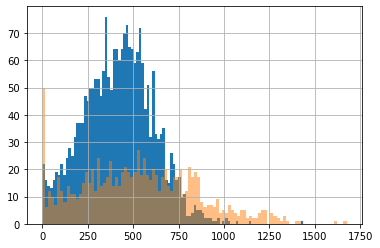

In [27]:
smart_users['duration'].hist(bins=100)
ultra_users['duration'].hist(bins=100, alpha=0.5);

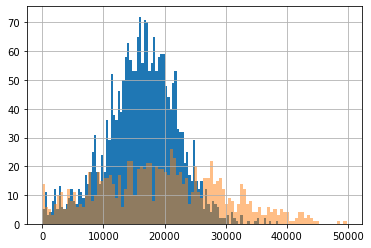

In [28]:
smart_users['mb_used'].hist(bins=100)
ultra_users['mb_used'].hist(bins=100, alpha=0.5);

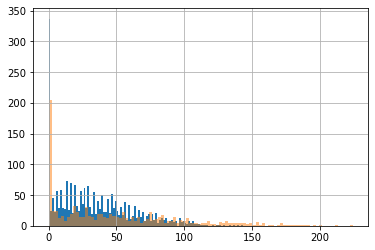

In [29]:
smart_users['messages_sum'].hist(bins=100)
ultra_users['messages_sum'].hist(bins=100, alpha=0.5);

Distributions can be described as follows:

     1. For calls - normal, beveled to the left
     2. For traffic - normal
     3. For messages - normal, strongly beveled to the right. The presence of an outlier at the beginning.

Allocations for smart users are different from ultra. They are more evenly distributed.

## Hypothesis testing

### The average revenue of users of Ultra and Smart tariffs differ

Let's formulate hypotheses.

1. Null hypothesis: the average revenue of users of the Ultra and Smart tariffs are equal.
2. Alternative hypothesis: the average revenues of users of the Ultra and Smart tariffs are different.

In [30]:
# Check for equality averages
alpha = 0.01 # critical level of statistical significance

# Assume that population variances are not equal
results = st.ttest_ind(smart_users['revenue'], ultra_users['revenue'], equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 1.2400298970835039e-249
Rejecting the null hypothesis


As a result, we find that the average revenues by tariffs differ.

### The average revenue of users from Moscow differs from the revenue of users from other regions

Let's formulate hypotheses.

1. Null hypothesis: the average revenue of users from Moscow is equal to the average revenue from users from other regions.
2. Alternative hypothesis: the average revenues of users from Moscow and other regions are different.

In [31]:
# Define users from Moscow and other settlements
Moscow_users = data_users[data_users['city'] == 'Москва']['user_id']
Other_users = data_users[data_users['city'] != 'Москва']['user_id']

In [32]:
# Determine the revenue of users from Moscow for the Smart category
Moscow_revenue_smart = smart_users.query('user_id in @Moscow_users')
Other_revenue_smart = smart_users.query('user_id in @Other_users')

# Same for Ultra category
Moscow_revenue_ultra = ultra_users.query('user_id in @Moscow_users')
Other_revenue_ultra = ultra_users.query('user_id in @Other_users')

In [33]:
# Get dataframes for revenue by city
Moscow_revenue = Moscow_revenue_smart.append(Moscow_revenue_ultra, ignore_index = True)
Other_revenue = Other_revenue_smart.append(Other_revenue_ultra, ignore_index = True)

In [34]:
# Check that the average for Moscow differs from the average for other regions
alpha = 0.01 # critical level of statistical significance

# Assume that population variances are not equal
results = st.ttest_ind(Moscow_revenue['revenue'], Other_revenue['revenue'], equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.5264663740569886
Failed to reject the null hypothesis


As a result, we find that the average revenues by location are approximately equal.

### Conclusion

User analysis was carried out for two different tariffs. The profitability for each of them is determined. Hypotheses about differences in average "checks" for each tariff and for user locations were tested.

As a result, it was found:
     1. The average revenue of the tariffs differs in favor of the ultra tariff
     2. Average revenue by location is almost the same
    
For the company, the ultra tariff will be more profitable, regardless of location. 